first I import libraries and set up the dataset.

In [128]:
#import libraries
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

#load weather.csv file as data
import os

path=os.path.join(os.path.dirname(os.getcwd()), 'data', 'weather.csv')
data=pd.read_csv(path)
#convert weather type to number
data['weather']=data['weather'].map({"sun":0,"drizzle":1,"rain":2,"fog":3,"snow":4})
#filter weather to only capture severity of rain and store result as weather_simplified.
weather_simplified = data[data['weather']<3]

here I use max temperature, minimum temperature, and weather with linear regression. Then I get the r2_score and MSE(Mean Squared Error).

In [129]:
#setting up training and testing for model
X = weather_simplified[['temp_max','temp_min','weather']]
y = weather_simplified['wind']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training the Multiple Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

#get models predictions
y_pred = model.predict(X_test)

#get r2_score and MSE from model
print(f"r2_score {model.score(X_test, y_test)}, MSE {mean_squared_error(y_test, y_pred)}")

r2_score 0.09032630284379839, MSE 1.76448241633206


The r2_score being so low means that there is very little correlation between the independent variables and the dependent variable. The MSE being so high means that the difference between the predicted values and the actual values is rather high.

here I create a polynomial version of the data to check for nom-linearity. I make a graph and show coefficients.

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


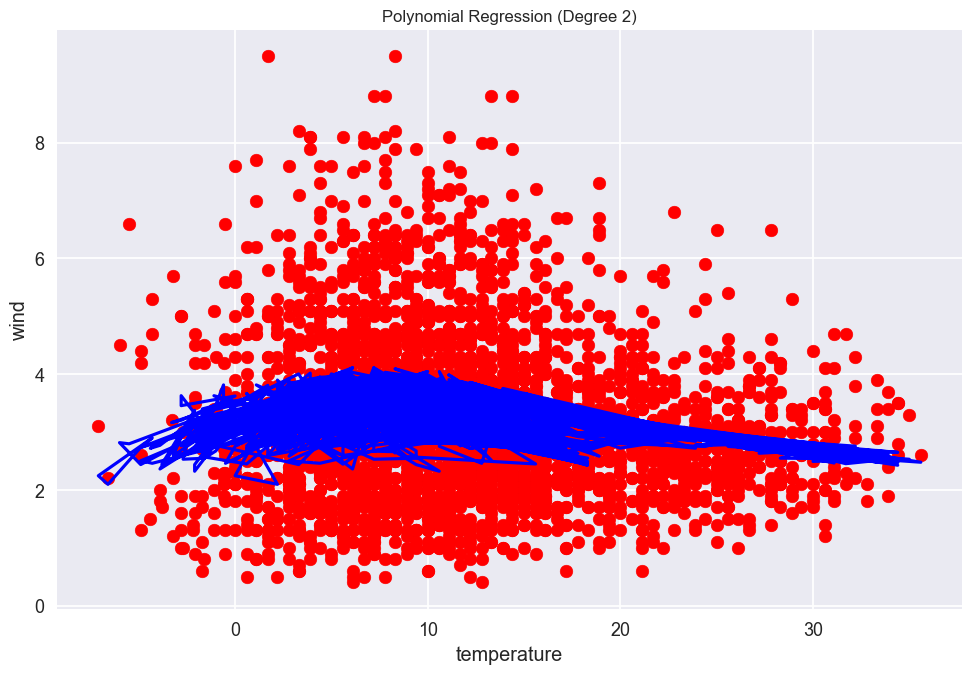

Coefficients: [ 0.         -0.16046813  0.21932648  0.00298518 -0.00255504 -0.00630338]
Intercept: 4.119906609324989


In [151]:
#setup polynomial features and setup data
poly = PolynomialFeatures(degree=2)
X=data[['temp_max','temp_min']]
y=data['wind']
X_poly = poly.fit_transform(X)

#create model
model = LinearRegression()
model.fit(X_poly, y)

# Make predictions
y_pred = model.predict(X_poly)

#display results
for column in X:
    plt.scatter(X[column], y, color='red')
    plt.plot(X[column], y_pred, color='blue')

print(plt.style.available)
plt.style.use('seaborn-v0_8-notebook')
plt.title('Polynomial Regression (Degree 2)')
plt.xlabel('temperature')
plt.ylabel('wind')
plt.show()

#print the coefficients and intercept
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

the graph seems to indicate that the data is nonlinear based on the curve of the data as shown by the blue lines.

Next I use stepwise and best subset selection to find the best values to use for the model.

In [131]:
#import libraries for stepwise and best subset selection
from sklearn.feature_selection import SequentialFeatureSelector
import itertools

#setup data for stepwise and best subset selection
X=data[[c for c in data if c not in ['date','wind']]]
y=data['wind']

#create model
model = LinearRegression()

#stepwise selection with 2 features
sfs = SequentialFeatureSelector(model, n_features_to_select=2, direction='forward')
sfs.fit(X, y)

selected_features = X.columns[sfs.get_support()]
print(f"Selected features (forward): {selected_features}")

#function for getting the best subset selection
def best_subset_selection(X, y):
    best_score = float('inf')
    best_subset = None

    #iterate over all possible subsets of features
    for k in range(1, len(X.columns) + 1):
        for subset in itertools.combinations(X.columns, k):
            #fit model on current subset
            model = LinearRegression()
            model.fit(X[list(subset)], y)
            y_pred = model.predict(X[list(subset)])
            score = mean_squared_error(y, y_pred)
            #update best score and subset if current model is better
            if score < best_score:
                best_score = score
                best_subset = subset

    return best_subset, best_score

best_features, best_mse = best_subset_selection(X, y)
print(f"Best features: {best_features}, MSE: {best_mse}")

Selected features (forward): Index(['precipitation', 'temp_max'], dtype='object')
Best features: ('precipitation', 'temp_max', 'temp_min', 'weather'), MSE: 1.8167129007299363


The best 2 values to use for the model are precipitation and temp max, but the best subset includes all the values.

Next I compute the VIF(Variance Inflation Factor) scores.

In [132]:
#import libraries for computing VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#setting values and adding a constant to calculate VIF for
X = add_constant(data[[c for c in data if c not in ['date']]])

#set up VIF and calculate for each value
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        Variable        VIF
0          const  19.366013
1  precipitation   1.303752
2       temp_max   5.701006
3       temp_min   4.941618
4           wind   1.137178
5        weather   1.399480


Here we see that temp_max(maximum temperature) and temp_min(minimum temperature) have a moderate VIF score, but the constant value has a very high score, which means that the variables likely have a small variance.

Next I will be doing residual analysis and making graphs to visualize.

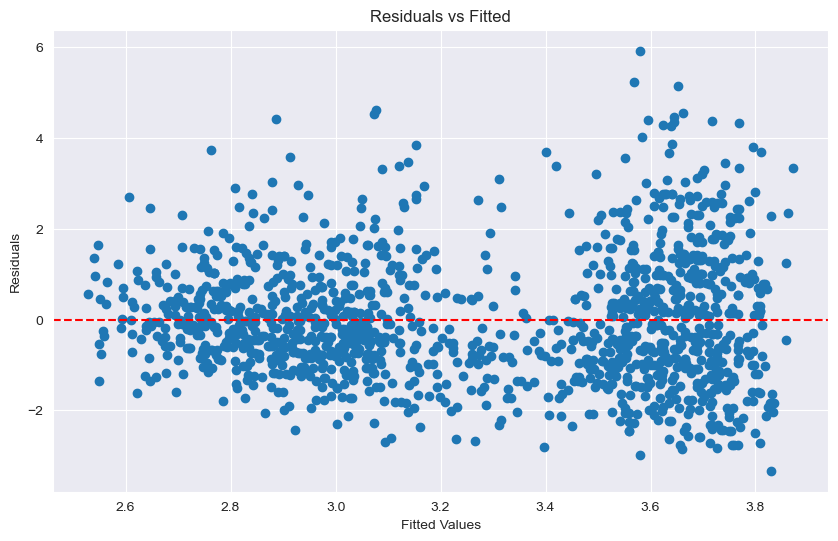

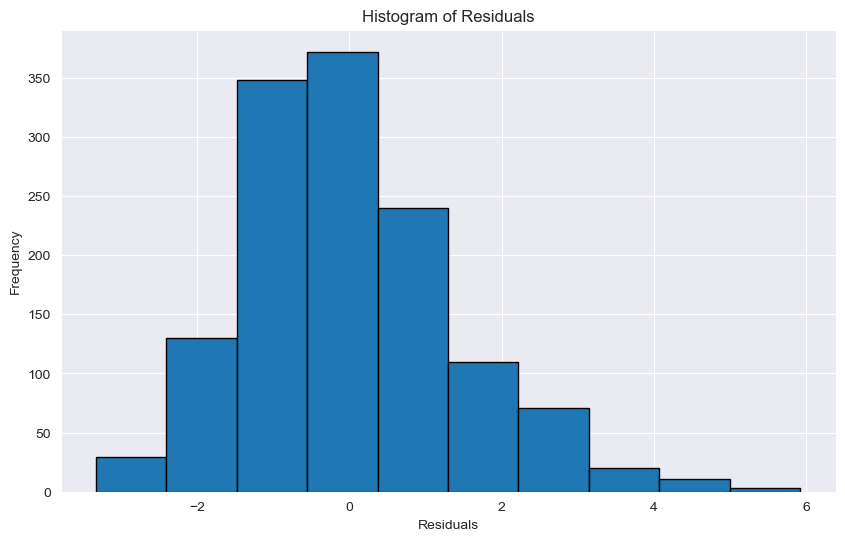

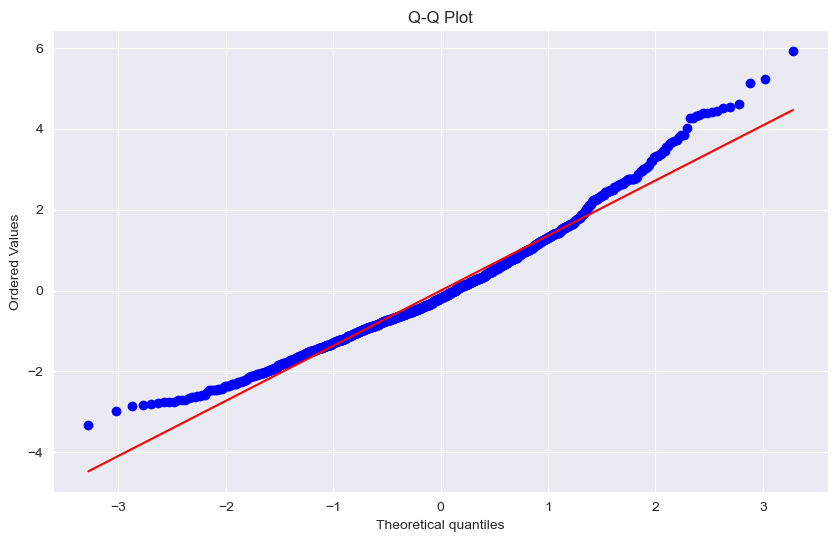

In [133]:
#import library for residual analysis
import statsmodels.api as sm

#setup data for model
X=weather_simplified[['temp_max','temp_min','weather']]
y=weather_simplified['wind']
X=sm.add_constant(X)

#create model
model = sm.OLS(y, X).fit()
y_pred = model.predict(X)

#calculate residuals
residuals = y - y_pred

#plotting residuals along fitted
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#plotting histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=10, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#importing library for Q-Q plot
import scipy.stats as stats

#creating Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

The Residuals vs Fitted plot doesn't show any big patterns, however there does seem to be slightly more residuals above 0 than below. The Residuals histogram shows that 0 is the most common which is good, but it also isn't A even bell shape, which  indicates that it is not entirely linear, but it does have some similarities with being linear. Finally, we have the Q-Q plot which shows that the values are close to being linear but are not linear.

Finally, I view the coefficients and predicted values.

In [134]:
#setup data
X=weather_simplified[['temp_max','temp_min','weather']]
y=weather_simplified['wind']

#setup training and testing for model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train model
model = LinearRegression()
model.fit(X_train, y_train)

#get model predictions
y_pred = model.predict(X)

#print coefficients
print(f"coefficients: {model.coef_}")

#setup data to show predictions alongside other data
temp_data=weather_simplified[['temp_max','temp_min','weather','wind']].copy()
temp_data["predicted_wind"]=y_pred
print(temp_data)

coefficients: [-0.04636766  0.04777541  0.24028085]
      temp_max  temp_min  weather  wind  predicted_wind
0         12.8       5.0        1   4.7        3.302631
1         10.6       2.8        2   4.5        3.539815
2         11.7       7.2        2   2.3        3.699022
3         12.2       5.6        2   4.7        3.599397
4          8.9       2.8        2   6.1        3.618640
...        ...       ...      ...   ...             ...
1455       4.4       0.0        0   2.5        3.212961
1456       4.4       1.7        2   2.9        3.774741
1457       5.0       1.7        2   1.3        3.746921
1459       5.6      -1.0        0   3.4        3.109545
1460       5.6      -2.1        0   3.5        3.056992

[1334 rows x 5 columns]


The predictions seem to all be very similar, which likely means the other values don't have a large impact on the wind.